# Symmetric model evaluation

In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats



In [2]:
fname = f'/Models/Evaluation/eval_dataset7_sym.tsv'
D = pd.read_csv(ut.model_dir + fname, delimiter='\t')
crits = ['dcbc_group','dcbc_indiv','coserr_group',
        'coserr_floor','coserr_ind2','coserr_ind3']

# Leave-one-out indicator
loo = [ True if len(train.split(" ")) == 6 else False for t,train in enumerate(D.train_data) ]
individual = [ True if len(train.split(" ")) == 1 else False for t,train in enumerate(D.train_data) ]
all = [ True if len(train.split(" ")) == 7 else False for t,train in enumerate(D.train_data) ]

D['train_type_detailed'] = D['train_data']
D['train_type_detailed'][loo] = 'loo'
D['train_type_detailed'][all] = 'all'
D['train_type'] = D['train_type_detailed']
D['train_type'][individual] = 'individual'
D['symmetric'] = True

D.tail()

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_24326/3244027870.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['train_type_detailed'][loo] = 'loo'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_24326/3244027870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D['train_type_detailed'][all] = 'all'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_24326/3244027870.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,model_name,atlas,K,train_data,train_loglik,test_data,indivtrain_ind,indivtrain_val,subj_num,common_kappa,...,dcbc_indiv,model_type,session,coserr_group,coserr_floor,coserr_ind2,coserr_ind3,train_type_detailed,train_type,symmetric
17755,sym_De,MNISymC3,68,['Demand'],928389.375,Somatotopic,half,2,3,False,...,0.556143,Models_04,all,0.838239,0.161322,0.401101,0.422467,['Demand'],individual,True
17756,sym_De,MNISymC3,68,['Demand'],928389.375,Somatotopic,half,2,4,False,...,0.618307,Models_04,all,0.749422,0.112141,0.351653,0.369509,['Demand'],individual,True
17757,sym_De,MNISymC3,68,['Demand'],928389.375,Somatotopic,half,2,5,False,...,0.414437,Models_04,all,0.805452,0.161828,0.466606,0.486396,['Demand'],individual,True
17758,sym_De,MNISymC3,68,['Demand'],928389.375,Somatotopic,half,2,6,False,...,0.401009,Models_04,all,0.817522,0.128680,0.560794,0.564280,['Demand'],individual,True
17759,sym_De,MNISymC3,68,['Demand'],928389.375,Somatotopic,half,2,7,False,...,0.282161,Models_04,all,0.920790,0.217382,0.415150,0.483935,['Demand'],individual,True


In [6]:
fname = f'/Models/Evaluation/eval_dataset7_asym.tsv'
Dasym = pd.read_csv(ut.model_dir + fname, delimiter='\t')
crits = ['dcbc_group','dcbc_indiv','coserr_group',
        'coserr_floor','coserr_ind2','coserr_ind3']

# Leave-one-out indicator
loo = [ True if len(train.split(" ")) == 6 else False for t,train in enumerate(Dasym.train_data) ]
individual = [ True if len(train.split(" ")) == 1 else False for t,train in enumerate(Dasym.train_data) ]
all = [ True if len(train.split(" ")) == 7 else False for t,train in enumerate(Dasym.train_data) ]

Dasym['train_type_detailed'] = Dasym['train_data']
Dasym['train_type_detailed'][loo] = 'loo'
Dasym['train_type_detailed'][all] = 'all'
Dasym['train_type'] = Dasym['train_type_detailed']
Dasym['train_type'][individual] = 'individual'
Dasym['symmetric'] = False


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/277916727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dasym['train_type_detailed'][loo] = 'loo'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/277916727.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dasym['train_type_detailed'][all] = 'all'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/277916727.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [7]:
D_hcp = pd.read_csv(ut.model_dir + '/Models/Evaluation/eval_all_sym_K-10_20_34_MdPoNiIbWmDeSoHc_leftOneOut.tsv', delimiter='\t')

# Leave-one-out indicator
loo = [ True if len(train.split(" ")) == 7 else False for t,train in enumerate(D_hcp.train_data) ]
individual = [ True if len(train.split(" ")) == 1 else False for t,train in enumerate(D_hcp.train_data) ]
all = [ True if len(train.split(" ")) == 8 else False for t,train in enumerate(D_hcp.train_data) ]

D_hcp['train_type_detailed'] = D_hcp['train_data']
D_hcp['train_type_detailed'][loo] = 'loo'
D_hcp['train_type_detailed'][all] = 'hcp'
D_hcp['train_type'] = D_hcp['train_type_detailed']
D_hcp['train_type'][individual] = 'individual'
D_hcp['symmetric'] = True
# D = D.append(D_hcp)

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/3735877488.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D_hcp['train_type_detailed'][loo] = 'loo'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/3735877488.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D_hcp['train_type_detailed'][all] = 'hcp'
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/3735877488.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [8]:
plt.figure(figsize=(10,6))
Dold=pd.read_csv(ut.base_dir + '/../Cerebellum/ProbabilisticParcellationModel/Models/Evaluation/asym/eval_dcbc_group_old.tsv',sep='\t')
Dold['name']=[s.split('_')[0] for s in Dold.model_name]
Dold['name'] = Dold['name'].astype('category').cat.reorder_categories([ 'atl-Anatom', 'atl-Ji10', 'atl-Buckner17', 'atl-Buckner7', 'atl-MDTB10', 'asym'])
Dold['symmetric'] = False



<Figure size 1000x600 with 0 Axes>

In [9]:
# Existing vs fused parcellation
existing = Dold[(Dold.name == 'atl-MDTB10')].dcbc
fused = D[(D.train_type == 'loo') & (D.model_type == 'Models_03') & (D.K == 10) & (D.test_data == 'MDTB')].dcbc_group

ttest = stats.ttest_ind(fused, existing)
print(ttest, fused.mean(), existing.mean())

Ttest_indResult(statistic=-6.833679182129384, pvalue=2.506996155172937e-09) 0.068353347 0.12611195529166666


Ttest_indResult(statistic=4.0055030050504445, pvalue=6.48129393300812e-05) 0.0862500478454955 0.07177924806018544


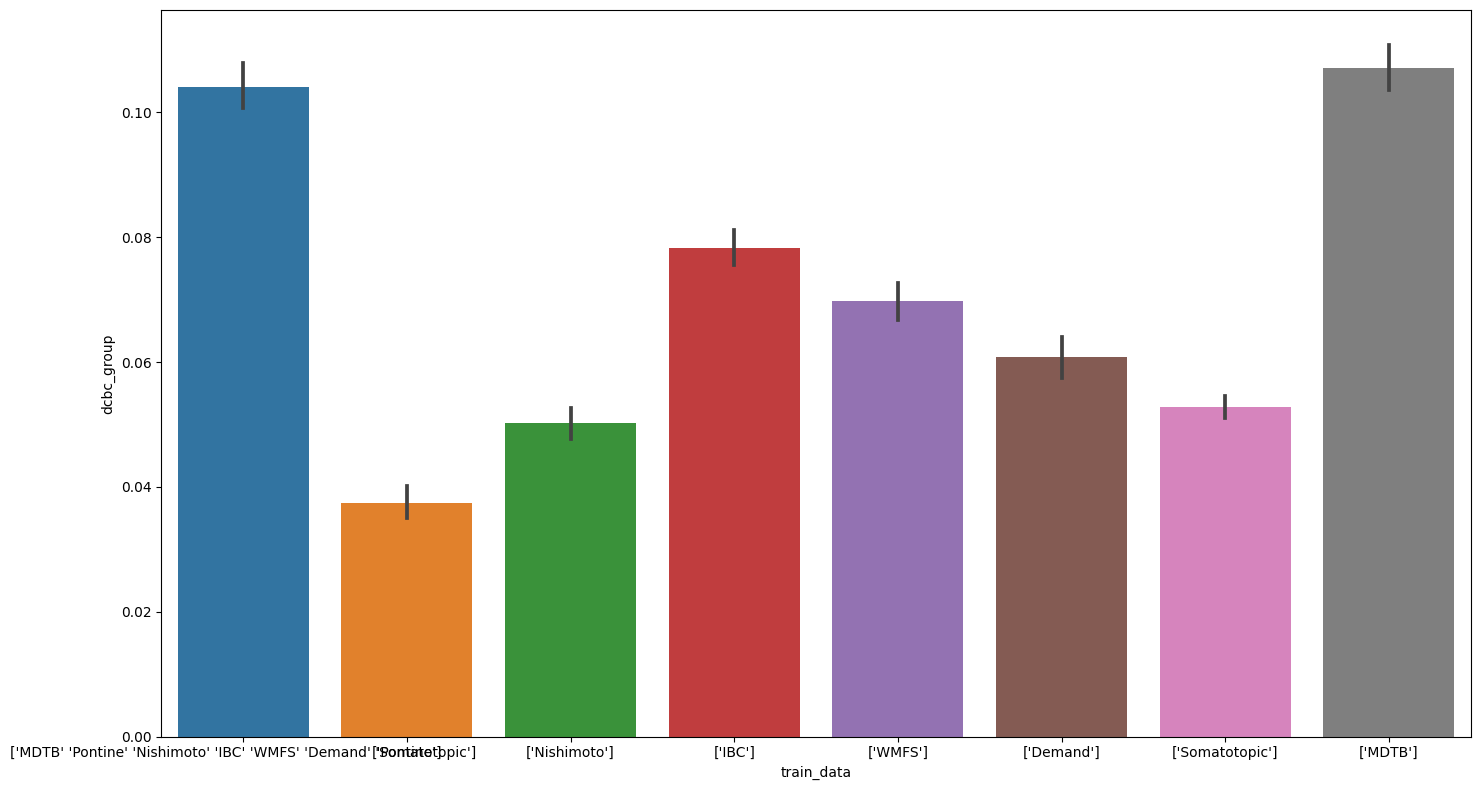

In [14]:
plt.figure(figsize=(15,8))
sb.barplot(data=D[(D.train_type != 'loo') & (D.model_type == 'Models_03')], x="train_data", y="dcbc_group")
plt.tight_layout()

fused = D[(D.train_type == 'loo') & (D.model_type == 'Models_03') & (D.K == 68) ].dcbc_group
indiv = D[(D.train_type == 'individual') & (D.model_type == 'Models_03')& (D.K == 68) ].dcbc_group

ttest = stats.ttest_ind(fused, indiv)
print(ttest, fused.mean(), indiv.mean())

In [15]:
# Asymmetric vs symmetric

sym = D[(D.train_type == 'loo') & (D.model_type == 'Models_03') & (D.K == 68) ].dcbc_group
asym = Dasym[(Dasym.train_type == 'individual') & (Dasym.model_type == 'Models_03')& (Dasym.K == 68) ].dcbc_group

ttest = stats.ttest_ind(sym, asym)
print(ttest, sym.mean(), asym.mean())

sym = D[(D.train_type == 'loo') & (D.model_type == 'Models_03') & (D.K == 10) ].dcbc_group
asym = Dasym[(Dasym.train_type == 'individual') & (Dasym.model_type == 'Models_03')& (Dasym.K == 10) ].dcbc_group

ttest = stats.ttest_ind(sym, asym)
print(ttest, sym.mean(), asym.mean())
print(asym.mean() - sym.mean())

Ttest_indResult(statistic=7.75592564243326, pvalue=1.5775724259048593e-14) 0.0862500478454955 0.061446782351509015
Ttest_indResult(statistic=5.600482366646411, pvalue=2.524163028930335e-08) 0.07611327653675676 0.05847211192252253
-0.017641164614234227


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_23799/3557872594.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  D_sym_vs_asym = D.append(Dasym)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ttest_indResult(statistic=4.0055030050504445, pvalue=6.48129393300812e-05) 0.0862500478454955 0.07177924806018544
Ttest_indResult(statistic=7.75592564243326, pvalue=1.5775724259048593e-14) 0.0862500478454955 0.061446782351509015
-0.027777935922972972


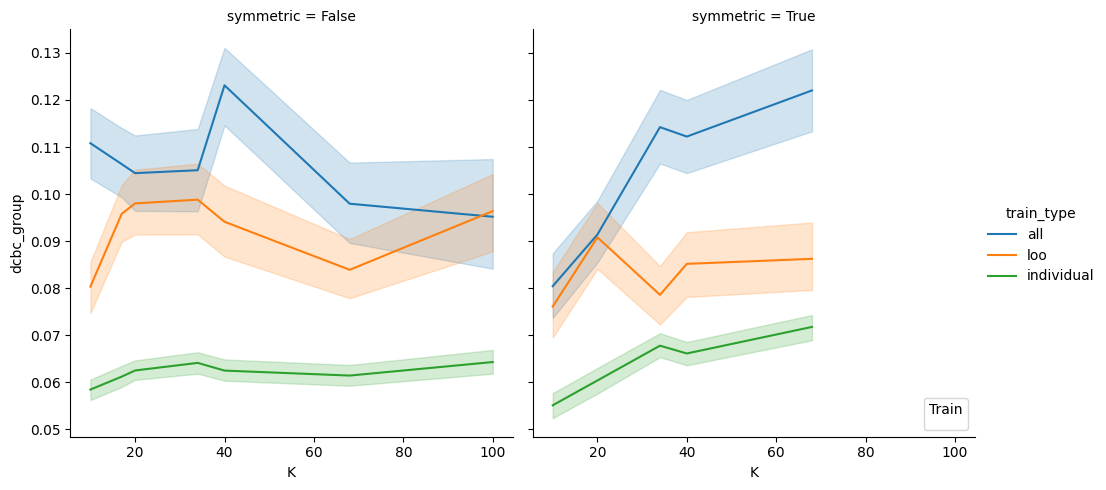

In [16]:
D_sym_vs_asym = D.append(Dasym)

# plt.figure(figsize=(8,8))
sb.relplot(data=D_sym_vs_asym[(D_sym_vs_asym.model_type == 'Models_03')  ], x="K", y="dcbc_group", hue="train_type",markers=True, col="symmetric", kind="line")
plt.legend(loc='lower right', title='Train')


# Asymmetric vs symmetric

sym = D[(D.train_type == 'loo') & (D.model_type == 'Models_03') & (D.K == 68) ].dcbc_group
indiv = D[(D.train_type == 'individual') & (D.model_type == 'Models_03')& (D.K == 68) ].dcbc_group

ttest = stats.ttest_ind(sym, indiv)
print(ttest, sym.mean(), indiv.mean())

sym = D[(D.train_type == 'loo') & (D.model_type == 'Models_03') & (D.K == 68) ].dcbc_group
indiv_asym = Dasym[(Dasym.train_type == 'individual') & (Dasym.model_type == 'Models_03')& (Dasym.K == 68) ].dcbc_group

ttest = stats.ttest_ind(sym, indiv_asym)
print(ttest, sym.mean(), indiv_asym.mean())
print(asym.mean() - sym.mean())

### Evaluation across K

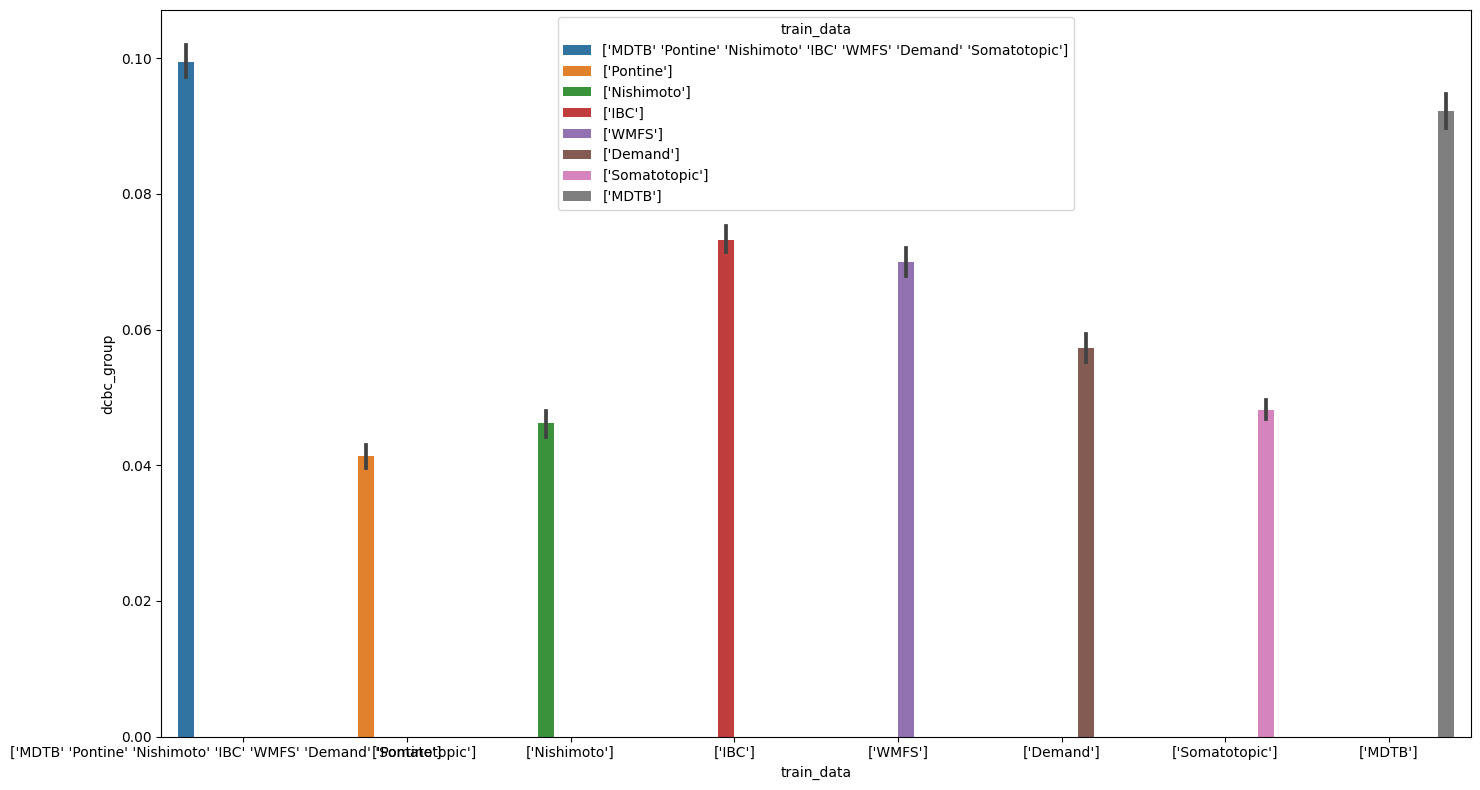

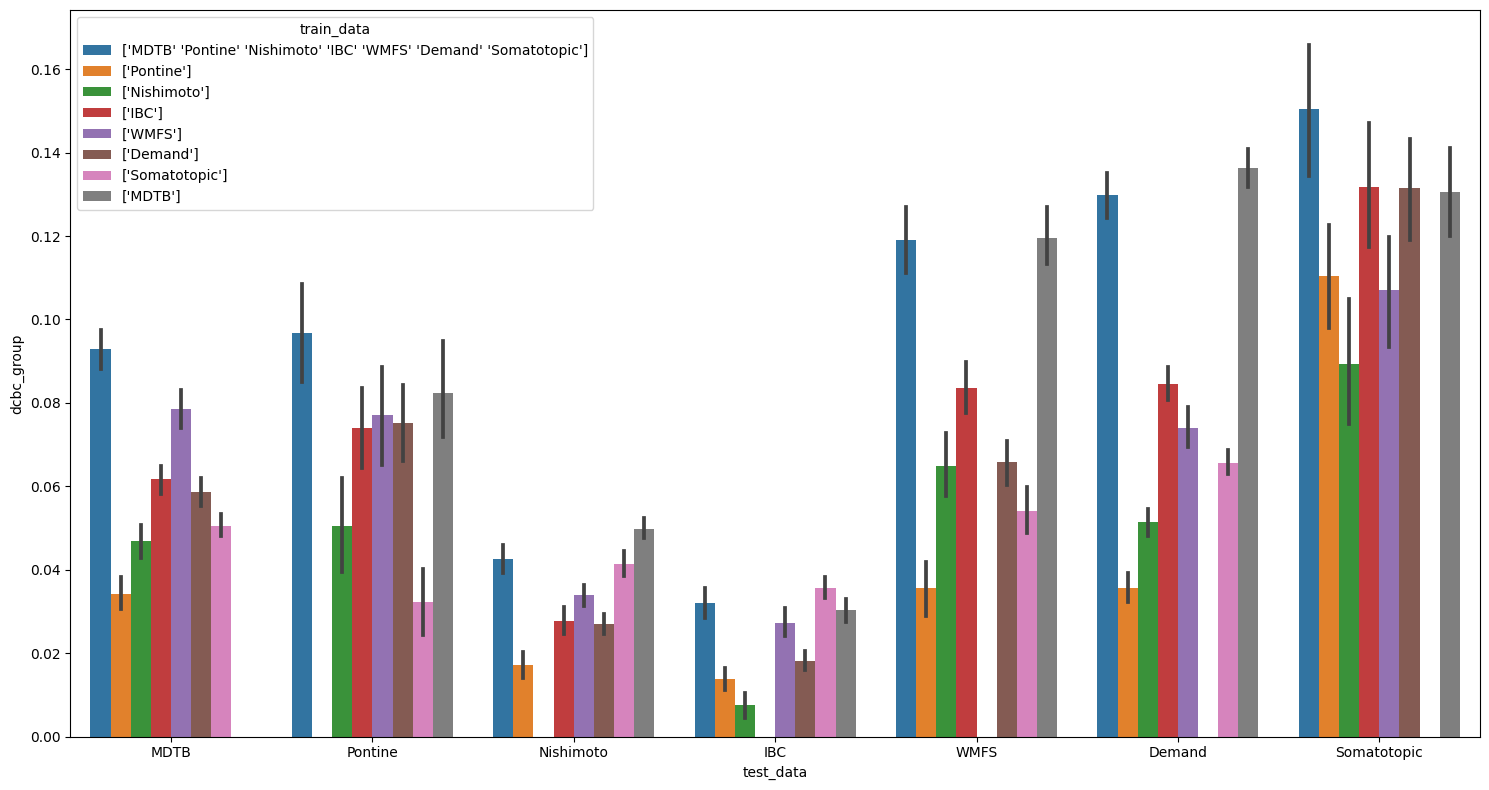

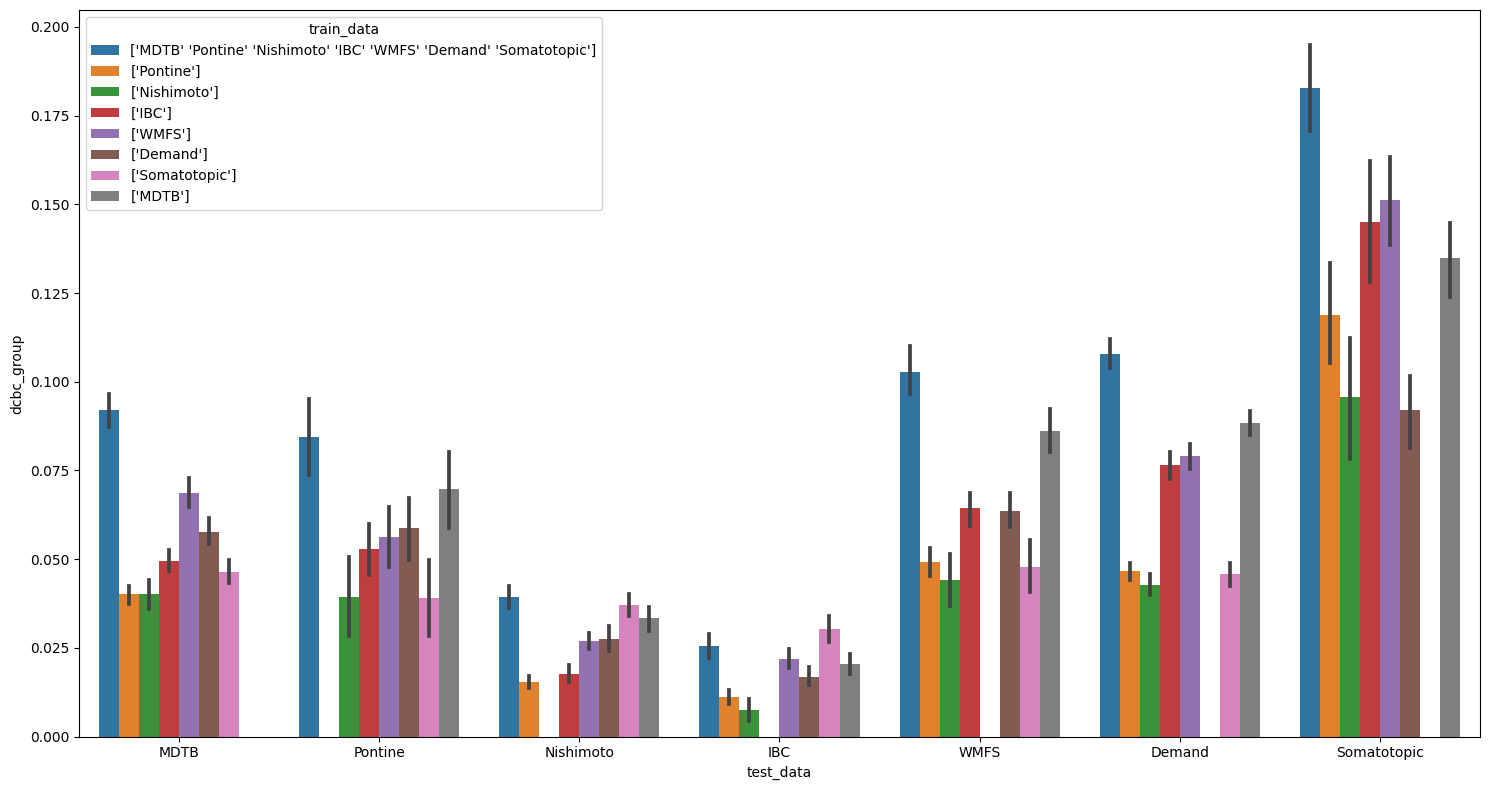

In [17]:
plt.figure(figsize=(15,8))
sb.barplot(data=D[D.train_type != 'loo'], x="train_data", y="dcbc_group", hue="train_data")
plt.tight_layout()

plt.figure(figsize=(15,8))
sb.barplot(data=D[(D.train_type != 'loo') & (D.model_type == 'Models_03')], x="test_data", y="dcbc_group", hue="train_data")
plt.tight_layout()

plt.figure(figsize=(15,8))
sb.barplot(data=D[(D.train_type != 'loo') & (D.model_type == 'Models_04')], x="test_data", y="dcbc_group", hue="train_data")
plt.tight_layout()


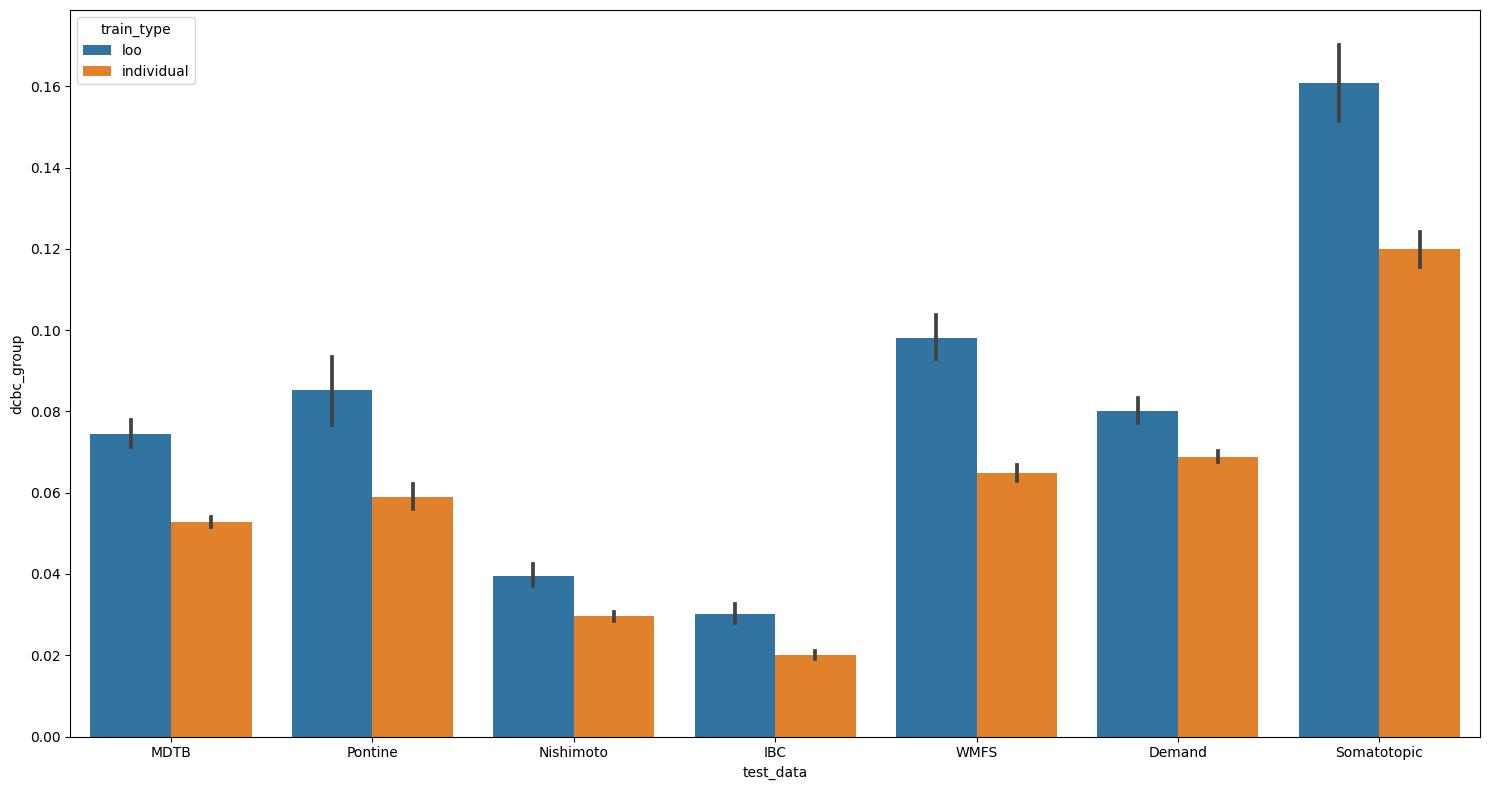

In [18]:
plt.figure(figsize=(15,8))
sb.barplot(data=D[(D.train_type == 'loo' )| (D.train_type == 'individual')], x="test_data", y="dcbc_group", hue="train_type")
plt.tight_layout()


## Evaluation on different Ks

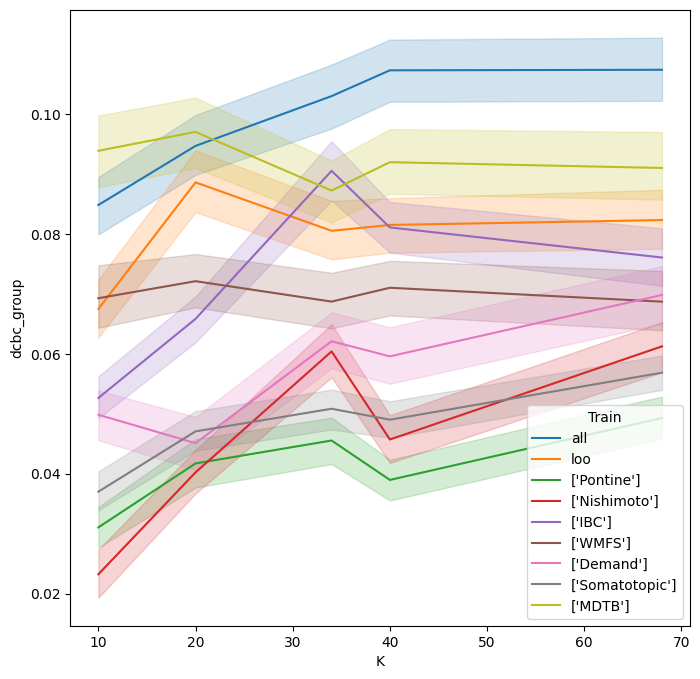

In [19]:
plt.figure(figsize=(8,8))
sb.lineplot(data=D, x="K", y="dcbc_group", hue="train_type_detailed",markers=True)
plt.legend(loc='lower right', title='Train')

Text(0.5, 1.0, 'Model 04')

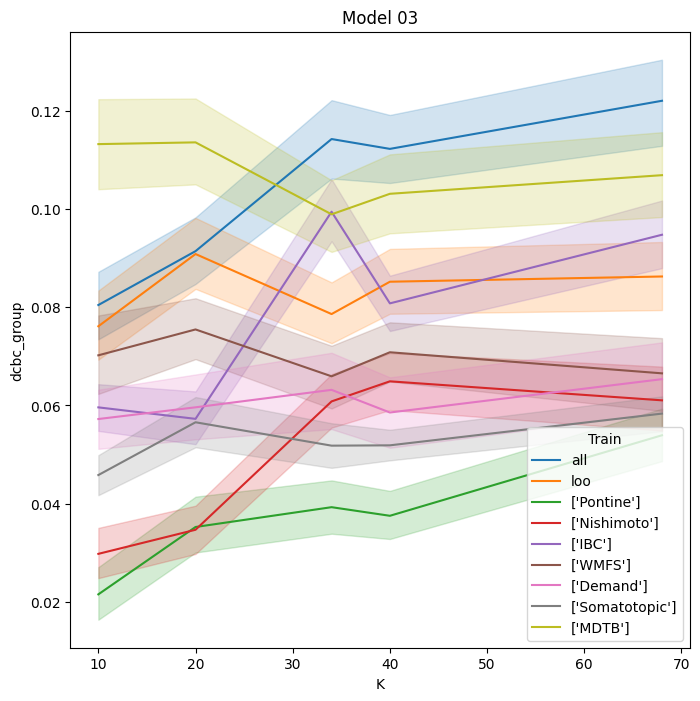

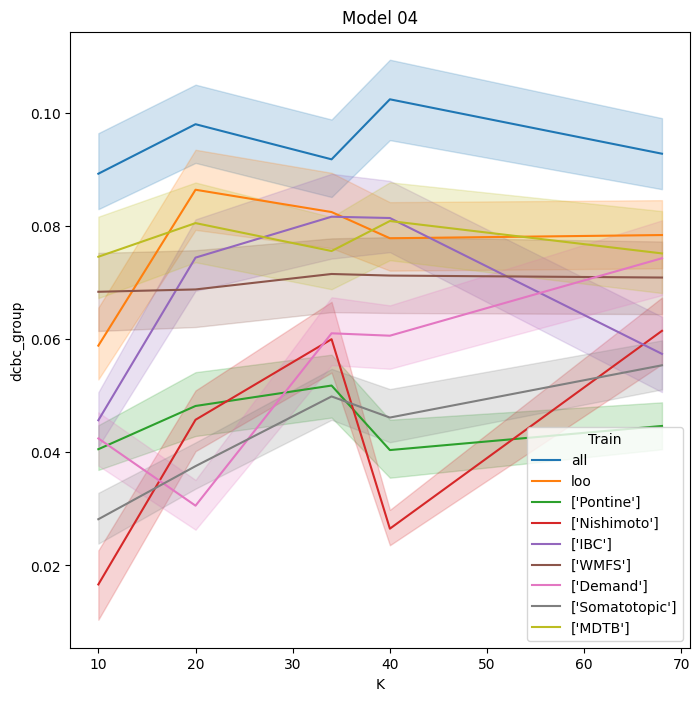

In [20]:
plt.figure(figsize=(8,8))
sb.lineplot(data=D[D.model_type == 'Models_03'], x="K", y="dcbc_group", hue="train_type_detailed",markers=True)
plt.legend(loc='lower right', title='Train')
plt.title('Model 03')

plt.figure(figsize=(8,8))
sb.lineplot(data=D[D.model_type == 'Models_04'], x="K", y="dcbc_group", hue="train_type_detailed",markers=True)
plt.legend(loc='lower right', title='Train')
plt.title('Model 04')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


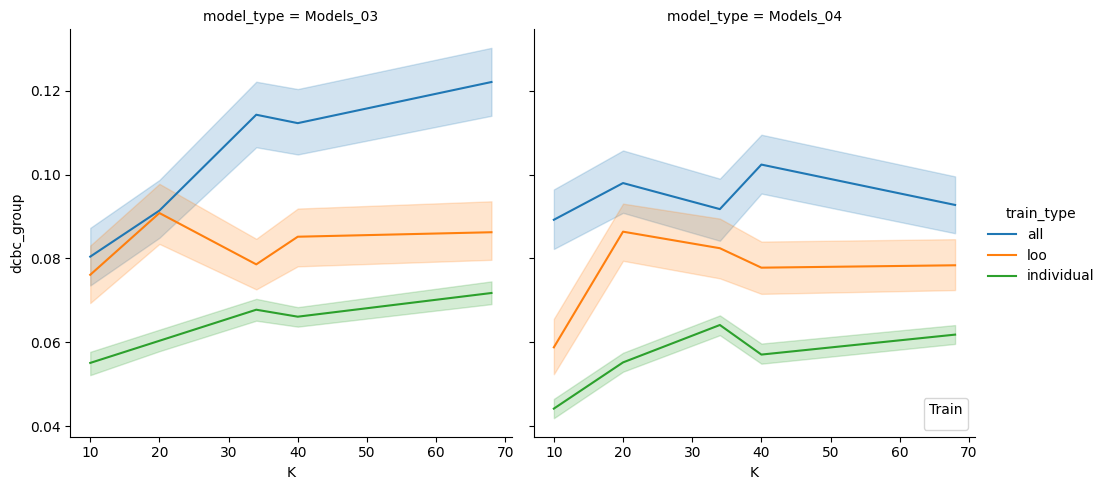

In [21]:
# plt.figure(figsize=(8,8))
# sb.lineplot(data=D[D.model_type == 'Models_03'], x="K", y="dcbc_group", hue="train_type",markers=True)
# plt.legend(loc='lower right', title='Train')
# plt.title('Model 03')

# plt.figure(figsize=(8,8))
# sb.lineplot(data=D[D.model_type == 'Models_04'], x="K", y="dcbc_group", hue="train_type",markers=True)
# plt.legend(loc='lower right', title='Train')
# plt.title('Model 04')

# plt.figure(figsize=(8,8))
sb.relplot(data=D, x="K", y="dcbc_group", hue="train_type",markers=True, col="model_type", kind="line")
plt.legend(loc='lower right', title='Train')


<Figure size 800x800 with 0 Axes>

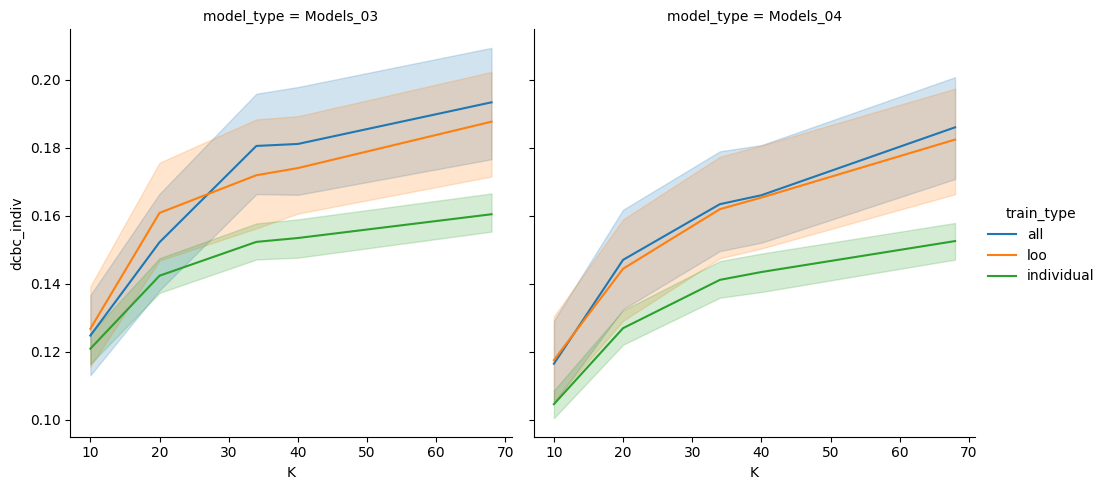

In [22]:
plt.figure(figsize=(8,8))
sb.relplot(data=D, x="K", y="dcbc_indiv", hue="train_type",markers=True, col="model_type", kind="line")


<Figure size 800x800 with 0 Axes>

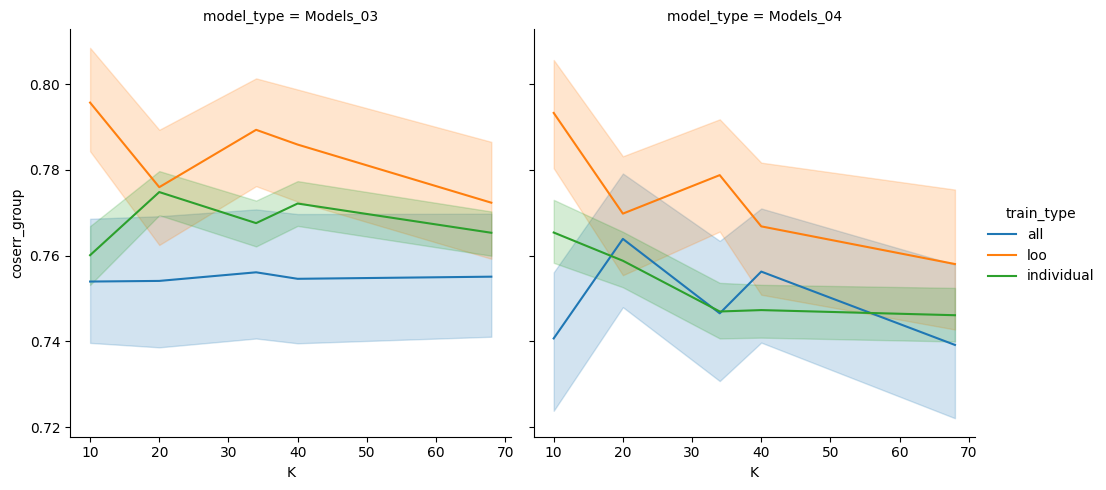

In [23]:
plt.figure(figsize=(8,8))
sb.relplot(data=D, x="K", y="coserr_group", hue="train_type",markers=True, col="model_type", kind="line")


<Figure size 800x800 with 0 Axes>

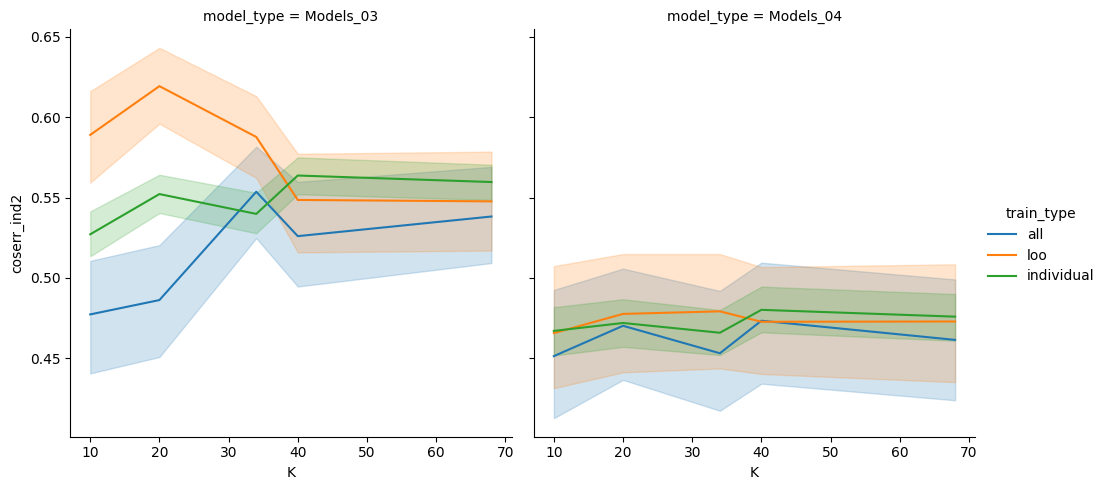

In [24]:
plt.figure(figsize=(8,8))
sb.relplot(data=D, x="K", y="coserr_ind2", hue="train_type",markers=True, col="model_type", kind="line")


<Figure size 800x800 with 0 Axes>

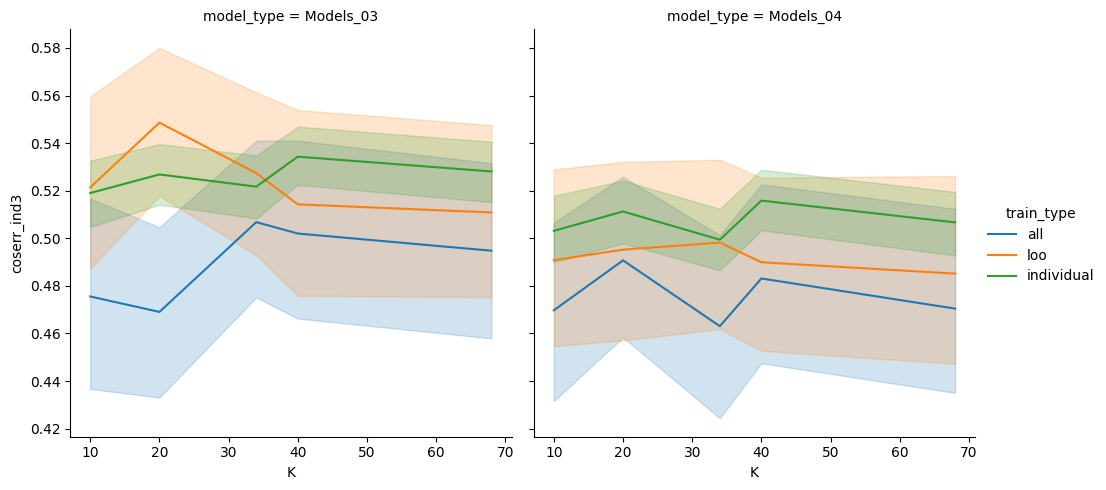

In [25]:
plt.figure(figsize=(8,8))
sb.relplot(data=D, x="K", y="coserr_ind3", hue="train_type",markers=True, col="model_type", kind="line")
